This notebook is taking data and computing its persistence diagram, determining the energy computation and applying PCA and TDR

In [1]:
import time
import numpy as np
from scipy.spatial import distance

#topological data analysis
from ripser import ripser
from persim import plot_diagrams

#plotting and visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.patches import Circle

import matplotlib.pyplot as plt
%matplotlib inline

import math
import cmath
from definitions import pentagon

import random
# import numpy as np

#manifold learning and dim red
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding as LLE

#topological data analysis
from dreimac import CircularCoords, CircleMapUtils

#plotting and visualization
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output, no_update
import plotly.graph_objects as go
import pandas as pd
import base64

from matplotlib import cm
# import matplotlib.pyplot as plt
# %matplotlib inline


def plot_barcodes(diagrams, alpha_max, width = 1.5):
    max_dim = len(diagrams)
    fig, axs = plt.subplots(max_dim)
    fig.suptitle('Barcodes')
    for dim in range(max_dim):
        barcode = np.copy(diagrams[dim])
        ind_inf = np.isinf(barcode.T[1])
        barcode[ind_inf, 1] = alpha_max
        h = 1
        for i in range(len(barcode)):
            x = barcode[i]
            y = [h,h]
            axs[dim].plot(x, y, linestyle= '-', c='#1f77b4', linewidth = width)
            if ind_inf[i]:
                axs[dim].scatter([alpha_max],[h],  s=10, marker='>', c='#1f77b4')
            h += 1
        axs[dim].set_xlim(0, 1.05*alpha_max)
        axs[dim].set_ylim(0,h)
        axs[dim].get_yaxis().set_ticks([]);
        axs[dim].spines['right'].set_color('none')
        axs[dim].spines['top'].set_color('none')
        axs[dim].text(0.3,1,'$\mathrm{bcd}^{\mathcal{R}}_{'+str(dim)+'}(X)$', verticalalignment='bottom')

In [15]:
# upload the excel files using pandas

penta2 = np.loadtxt('data/genus 3 clean.txt', delimiter=',')

print(penta2.shape)

# print(2%%2)

SyntaxError: invalid syntax (1706486993.py, line 7)

[0.         0.         1.         0.         0.50501662 0.3391039
 1.04618085 0.59822023 1.04618085 0.59822023]
[0.0, 1.0, 0.5050166194970018, 1.0461808494370803, 1.0461808494370803]
[0.0, 0.0, 0.33910389709619104, 0.5982202343529565, 0.5982202343529565]


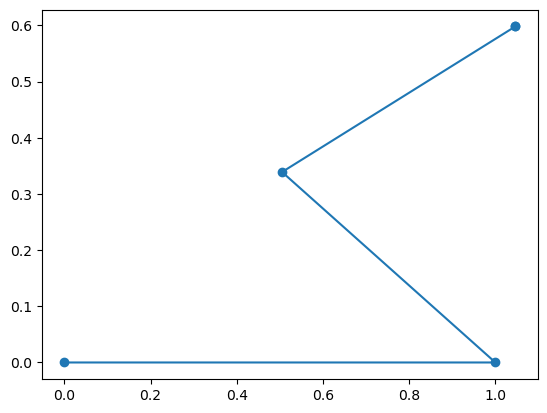

In [14]:
sample1 = penta2[101]
x_val = []
y_val = []

for i in range(10):
    if i%2 == 0:
        x_val.append(sample1[i])
    else: 
        y_val.append(sample1[i])

print(sample1)
print(x_val)
print(y_val)

plt.plot(x_val, y_val)
plt.scatter(x_val, y_val)

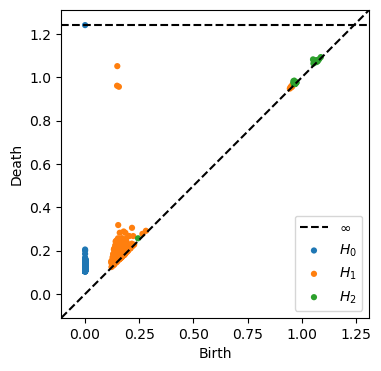

In [3]:
#Using Ripser, we will find the persistence diagrams
#Here I am referecing code from Demo 6 in Day 5 DREimac

n_land = 900
res = ripser(penta2, n_perm = n_land, maxdim=2, coeff =13, thresh = 1.8)
dgms = res['dgms']
plt.figure(figsize = (4,4))
plot_diagrams(dgms)

In [4]:
pers1 = dgms[1][:,1] - dgms[1][:,0]
pers2 = dgms[2][:,1] - dgms[2][:,0]

pers1_sorted = np.sort(pers1)[::-1]
pers2_sorted = np.sort(pers2[pers2 < np.Inf])[::-1]

print('Persistence of top 10 1-d features:\n', np.around(pers1_sorted[0:10],decimals=2), '\n')
print('Persistence of top 10 2-d features:\n', np.around(pers2_sorted[0:10],decimals=2))

n_lands = 1000

cc = CircularCoords(penta2 , n_landmarks= n_lands)

coho_classes = [0, 1, 3]

circular_coords = []

for i in coho_classes:
    circular_coords.append(cc.get_coordinates(perc = 0.6, cocycle_idx=i, standard_range= False))

print("space space")
print(circular_coords)
print("Shape of Circular Coords")
print(np.array(circular_coords).shape)

Persistence of top 10 1-d features:
 [0.9  0.81 0.8  0.17 0.12 0.11 0.11 0.1  0.1  0.1 ] 

Persistence of top 10 2-d features:
 [0.03 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.01 0.01]
space space
[array([1.35706771, 2.6329152 , 2.63291481, ..., 3.28893497, 3.29029683,
       0.74348264]), array([3.93323422, 1.57996694, 1.57996719, ..., 0.49378237, 0.48639666,
       4.93287164]), array([6.18086257, 5.74744193, 5.74744196, ..., 6.06091723, 6.06589826,
       0.05690115])]
Shape of Circular Coords
(3, 18027)


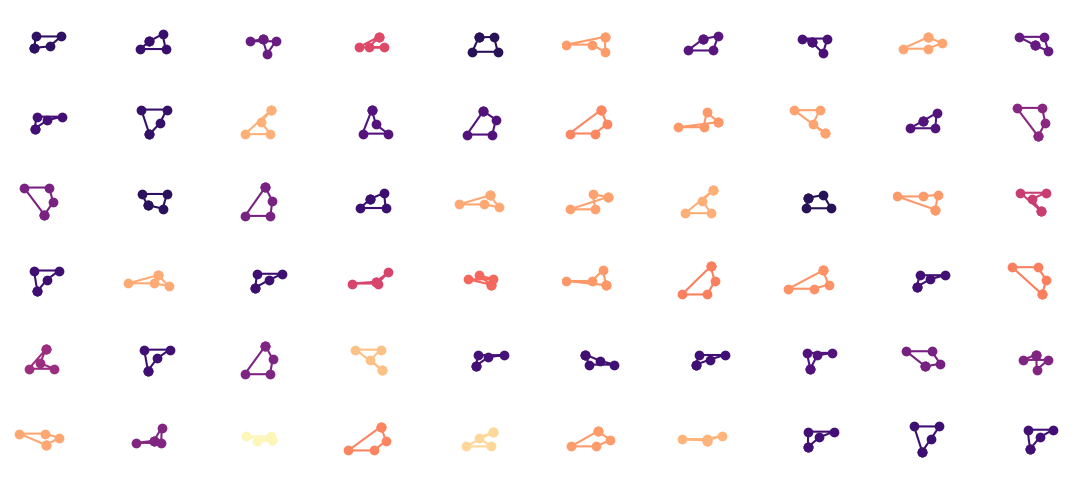

In [6]:
#Energy Computation

angle_data = np.zeros((penta2.shape[0],5)) # internal angles

for i in range(5):
    ii = (2*i -2)%10
    jj = (2*i - 1)%10
    u = penta2[:, [ii, jj]]
    
    ii = (2*i)%10
    jj = (2*i + 1)%10
    v = penta2[:, [ii , jj]]
    
    ii = (2*i + 2)%10
    jj = (2*i + 3)%10
    w = penta2[:, [ii, jj]]
    
    z = np.sum((u - v)*(w-v), axis = 1)
    
    angle_data[:,i]  = np.arccos( np.minimum(z,1) )
    
energy = np.sum((angle_data - (3/5)*np.pi)**2 , axis = 1)

# plot sample pentagons
plt.figure(figsize=(14,6))
for i in range(60):
    ind = random.randint(0, penta2.shape[0])
    x = penta2[ind].reshape(5,2).T
    cent = np.mean(x,axis=1)
    plt.subplot(6,10,i+1)
    plt.plot(x[0,range(-1,5)], x[1,range(-1,5)] , '-o', c= cm.magma(energy[ind]/np.max(energy)))
    plt.axis('square')
    plt.axis('off')
    plt.xlim(cent[0]-1.3,cent[0]+1.3);
    plt.ylim(cent[1]-1.3,cent[1]+1.3);

In [5]:
#Applying Circular coords and doing TDR

thetas= CircleMapUtils.linear_combination(np.array(circular_coords), [[1,1,1], [0,1,0],[0,1,1]])

theta1 = CircleMapUtils.center(thetas[0])
theta2 = CircleMapUtils.center(thetas[1])
theta3 = CircleMapUtils.center(thetas[2])


# Plot the data using the computed circular coordintaes, and colors given by pentagon energy
fig = go.Figure(data=[go.Scatter3d(
    x=theta1, y=theta2, z=theta3, 
    mode ='markers', 
    marker=dict(size = 3, color =energy, colorscale='plasma')
)])

fig.update_layout(autosize=False, width=700, height=700)

fig.show()

#Creating a 2D plot of thetas

# plt.scatter(theta1, theta2)
# plt.scatter(theta1, theta3)
plt.scatter(theta2, theta3)

NameError: name 'energy' is not defined

In [ ]:
#PCA
pca = PCA(n_components=5)
data_pca = pca.fit(penta2).transform(penta2)

print('Explained Variance', pca.explained_variance_ratio_)

fig = go.Figure(data=[go.Scatter3d(
    x=data_pca[:,0], y=data_pca[:,1], z=data_pca[:,2], 
    mode ='markers', 
    marker=dict(size = 3, color =energy, colorscale='plasma' , opacity = 1)
)])


fig.update_layout(autosize=False, width=700, height=700)  

fig.show()